In [1]:
import pandas as pd
import pmdarima as pm
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import set_config

#Configs
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format
warnings.filterwarnings('ignore')
set_config(transform_output='pandas')

In [2]:
#File names

path = './data/'
transactions = 'transactions.csv'
train = 'train.csv'
test = 'test.csv'
stores = 'stores.csv'
oil = 'oil.csv'
holidays_events = 'holidays_events.csv'

In [3]:
#Reading in csv files
df_train = pd.read_csv(path + train)
df_test = pd.read_csv(path + test)
df_stores = pd.read_csv(path + stores)
df_transactions = pd.read_csv(path + transactions)
df_oil = pd.read_csv(path + oil)
df_holidays = pd.read_csv(path + holidays_events)

In [4]:
df_test

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0
...,...,...,...,...,...
28507,3029395,2017-08-31,9,POULTRY,1
28508,3029396,2017-08-31,9,PREPARED FOODS,0
28509,3029397,2017-08-31,9,PRODUCE,1
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9


In [5]:
#Datetime conversion
df_train['date'] = pd.to_datetime(df_train['date'])
df_test['date'] = pd.to_datetime(df_test['date'])
df_oil['date'] = pd.to_datetime(df_oil['date'])
df_holidays['date'] = pd.to_datetime(df_holidays['date'])
df_transactions['date'] = pd.to_datetime(df_transactions['date'])

In [6]:
df_train.sort_values(by=['date'], inplace=True)
df_test.sort_values(by=['date'], inplace=True)
df_oil.sort_values(by=['date'], inplace=True)
df_holidays.sort_values(by=['date'], inplace=True)
df_transactions.sort_values(by=['date'], inplace=True)

In [7]:
#Missing data
df_oil.isnull().sum()

#Impute first value with second value
df_oil['dcoilwtico'][0] = df_oil['dcoilwtico'][1]

#Linear interpolation of missing values in oil timeseries
df_oil['dcoilwtico'] = df_oil['dcoilwtico'].interpolate(method='linear')

#Exploding the df_oil index to one continuous time series
df_oil = df_oil.set_index('date').resample('D').ffill().reset_index()
df_oil

,date,dcoilwtico
0,2013-01-01,93.14
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-05,93.12
...,...,...
1699,2017-08-27,47.65
1700,2017-08-28,46.40
1701,2017-08-29,46.46
1702,2017-08-30,45.96


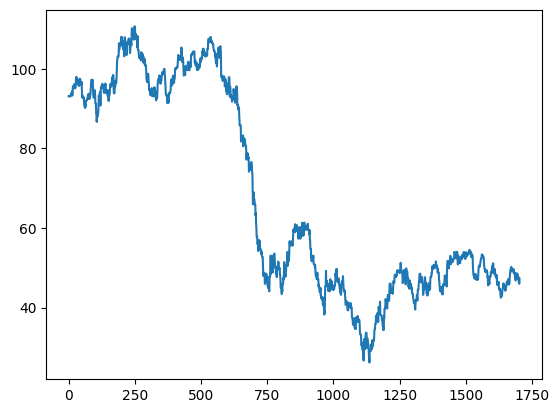

In [8]:
#Convert df_oil to price difference from previous day in percent
df_oil['dcoilwtico'].plot()
df_oil['dcoilwtico'] = df_oil['dcoilwtico'].pct_change()
df_oil['price_shock'] = df_oil['dcoilwtico'].apply(lambda x: 1 if x > 0.10 or x < -0.10 else 0)

In [9]:
#Adding transactions, holidays, oil prices and store information to train and test, and setting date as index
df_train = df_train.merge(df_transactions, on=['date', 'store_nbr'], how='left')
df_train = df_train.merge(df_oil, on=['date'], how='left')
df_train = df_train.merge(df_stores, on=['store_nbr'], how='left')

df_test = df_test.merge(df_transactions, on=['date', 'store_nbr'], how='left')
df_test = df_test.merge(df_oil, on=['date'], how='left')
df_test = df_test.merge(df_stores, on=['store_nbr'], how='left')

#Adding payday flags on 1st and 15th of each month
df_train['payday'] = df_train['date'].dt.day.isin([1, 15]).astype(int)
df_test['payday'] = df_test['date'].dt.day.isin([1, 15]).astype(int)

#Drop type column
df_train.drop('type', axis=1, inplace=True)
df_test.drop('type', axis=1, inplace=True)

<Axes: title={'center': 'Sales by date'}, xlabel='date'>

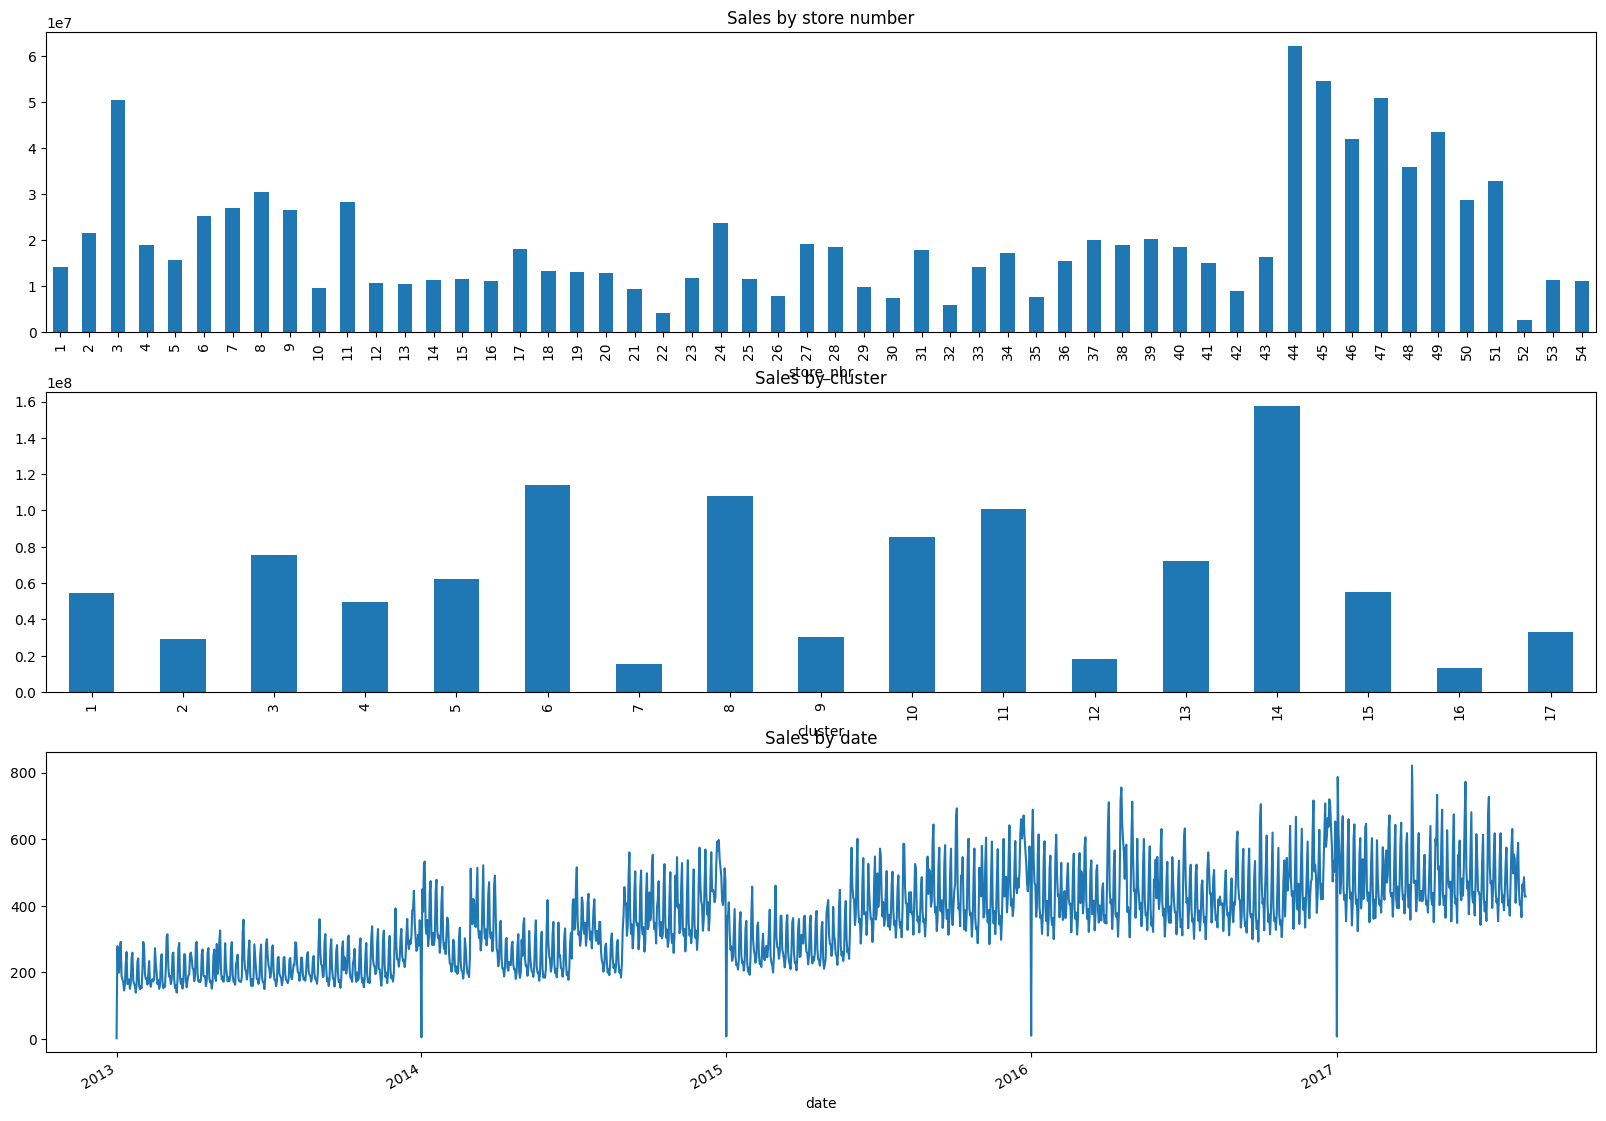

In [10]:
#Comparing sales across store_nbd
fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(20,15))
df_train.groupby('store_nbr')['sales'].sum().plot(kind='bar', ax=ax1, title='Sales by store number')
df_train.groupby('cluster')['sales'].sum().plot(kind='bar', ax=ax2, title='Sales by cluster')
df_train.groupby('date')['sales'].mean().plot(ax=ax3, title='Sales by date')

In [11]:
def process_holidays(df, df_holidays):
    '''
    Function to process holidays events
    '''

    #Dropping duplicate holidays by locale_name and date
    df_holidays = df_holidays.drop_duplicates(subset=['locale_name', 'date'])

    #Getting local, regional and national holiday dfs
    df_holidays_local = df_holidays[df_holidays['locale'] == 'Local']
    df_holidays_regional = df_holidays[df_holidays['locale'] == 'Regional']
    df_holidays_national = df_holidays[df_holidays['locale'] == 'National']

    #Merging holiday dfs with train dataset
    df = df.merge(df_holidays_local, left_on=['date', 'city'], right_on= ['date', 'locale_name'], how='left')
    df = df.merge(df_holidays_regional, left_on=['date', 'state'], right_on= ['date', 'locale_name'], how='left')
    df = df.merge(df_holidays_national, on=['date'], how='left')

    #Adding new year flag
    df['new_years'] = df['date'].apply(lambda x: 1 if x.month == 1 and x.day == 1 else 0)

    #Dropping unnecessary columns created in joining holiday dfs
    df.drop(columns=['locale_x', 'locale_name_x', 'description_x', 'locale_y', 'locale_name_y', 'description_y', 'locale', 'locale_name', 'transferred'], inplace=True)

    #Generating one event_type column which is the type of holiday if there is one, and has 'normal' if not
    df['event_type'] = df['type_x'].fillna(df['type_y']).fillna(df['type']).fillna('normal')
    
    #Add earthquake impact
    df['earthquake'] = df['date'].apply(lambda x: 1 if x.month == 4 and x.day == 16 and x.year == 2016 else 0)
    df['earthquake_impact'] = df['date'].apply(lambda x: 1 if 4 <= x.month <= 5 and x.year == 2016 else 0)
    
    #Add back to school flags
    df['back_to_school'] = df['date'].apply(lambda x: 1 if 7 <= x.month <= 9 else 0)

    #Dropping unnecessary type and transferred columns
    df.drop(columns=['type_x', 'type_y', 'type', 'transferred_x', 'transferred_y'], inplace=True)

    #Find dates where stores are closed (meaning sum of sales is 0 for a store_nbr)
    if 'sales' in df.columns:
        df['closed'] = df.groupby(['date', 'store_nbr'])['sales'].transform(lambda x: 1 if x.sum() == 0 else 0)
    return df

In [12]:
#Apply preprocessing functions to train and test sets
df_train = process_holidays(df_train, df_holidays)
df_test = process_holidays(df_test, df_holidays)

In [ ]:
#Get df with closed store dates for each store_nbr
df_closed = df_train.loc[df_train.closed == 1].copy()
df_closed = df_closed[['date', 'store_nbr', 'city', 'closed']]
df_closed['month'] = df_closed.date.dt.month
df_closed['day'] = df_closed.date.dt.day
df_closed.drop(columns=['date'], inplace=True)
df_closed.drop_duplicates(inplace=True)
df_closed

In [ ]:
df_test['month'] = df_test.date.dt.month
df_test['day'] = df_test.date.dt.day
df_test['year'] = df_test.date.dt.year

#Merge in closed based on month, day, city and store_nbr
df_test = df_test.merge(df_closed[['month', 'day', 'city', 'store_nbr', 'closed']], on=['month', 'day', 'city', 'store_nbr'], how='left')
df_test.closed.fillna(0, inplace=True)
df_test

In [ ]:
df_train

In [ ]:
def process_date_columns(df_train_original, df_test_original):
    
    df_test_original['dayofweek'] = df_test_original.date.dt.dayofweek
    df_train_original['month'] = df_train_original.date.dt.month
    df_train_original['day'] = df_train_original.date.dt.day
    df_train_original['year'] = df_train_original.date.dt.year
    df_train_original['dayofweek'] = df_train_original.date.dt.dayofweek

    return df_train_original, df_test_original
    
df_train, df_test = process_date_columns(df_train, df_test)

In [ ]:
df_test

In [ ]:
def onehotencoder(df, columns):
    '''
    Function to one hot encode categorical variables
    '''
    for col in columns:
        categories = df[col].unique()
        for cat in categories:
            df[f"{col}_{cat}"] = df[col].apply(lambda x: 1 if x == cat else 0)
        df.drop(columns=col, inplace=True)
    return df

In [ ]:
df_train = onehotencoder(df_train, ["event_type", "day", "month", "year", "dayofweek"])
df_test = onehotencoder(df_test, ["event_type", "day", "month", "year", "dayofweek"])

for col in df_train.columns:
        if col not in df_test.columns and col != 'sales':
            df_test[col] = 0

In [ ]:
def get_single_store_nbr_family_dfs(df_train_original, df_test_original, store_nbr, family):

    drop_cols = [
        "id",
        "transactions",
        "city",
        "state",
        "cluster",
        "description",
        "dcoilwtico",
        "price_shock"
    ]

    df_train_filtered = df_train_original.drop(columns=drop_cols)
    df_train_filtered = df_train_filtered.loc[(df_train_filtered["store_nbr"] == store_nbr) & (df_train_filtered["family"] == family)].copy()

    if len(df_train_filtered) == 0:
        print(f"ERROR: No data found for store number {store_nbr} and family {family}!")
        return None, None, None

    df_test_filtered = df_test_original.drop(columns=drop_cols)
    df_test_filtered = df_test_filtered.loc[(df_test_filtered["store_nbr"] == store_nbr) & (df_test_filtered["family"] == family)].copy()
    
    df_val_filtered = df_train_filtered.loc[df_train_filtered["date"] >= pd.to_datetime("2017-08-01")].copy()
    df_train_filtered = df_train_filtered.loc[df_train_filtered["date"] < pd.to_datetime("2017-08-01")].copy()

    df_train_filtered.set_index("date", inplace=True)
    df_test_filtered.set_index("date", inplace=True)
    df_val_filtered.set_index("date", inplace=True)

    df_test_filtered.drop(columns=["store_nbr", "family"], inplace=True)

    return df_train_filtered, df_val_filtered, df_test_filtered

train, val, test = get_single_store_nbr_family_dfs(df_train, df_test, 42, "CELEBRATION")


def aggregate_sales_data_across_stores(family, df):

    df_category = df.loc[df["family"] == family].copy()
    df_category.drop(columns=["family", "id", "transactions", "description", "city", "state", "cluster", "store_nbr"], inplace=True)
    return df_category.groupby(["date"]).mean().reset_index()


def get_single_family_dfs(df_train_original, df_test_original, family):

    df_train_filtered = aggregate_sales_data_across_stores(family, df_train_original)
    df_test_filtered = aggregate_sales_data_across_stores(family, df_test_original)
    df_val_filtered = df_train_filtered.loc[df_train_filtered["date"] >= pd.to_datetime("2017-08-01")].copy()
    df_train_filtered = df_train_filtered.loc[df_train_filtered["date"] < pd.to_datetime("2017-08-01")].copy()

    df_train_filtered.set_index("date", inplace=True)
    df_test_filtered.set_index("date", inplace=True)
    df_val_filtered.set_index("date", inplace=True)

    return df_train_filtered, df_val_filtered, df_test_filtered

train, val, test = get_single_store_nbr_family_dfs(df_train, df_test, 42, "CELEBRATION")
#train, val, test = get_single_family_dfs(df_train, df_test, "AUTOMOTIVE")

In [ ]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_squared_log_error
import numpy as np

#set sklearn output to pandas
set_config(transform_output='pandas')

def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

def forecast(stores, family, df_train_full, df_test_full):
    '''
    function to forecast sales for a given store_nbr and family
    returns: forecasted sales for the next 16 days
    '''
    
    #training model on family data aggregated across store nums
    df_train, df_val, _ = get_single_family_dfs(df_train_full, df_test_full, family)
    arima_model = pm.auto_arima(df_train.sales, exogenous=df_train.drop('sales', axis=1), start_p=1, start_q=1)
    val_preds_arima = arima_model.predict(n_periods=len(df_val), exogenous= df_val.drop(columns=["sales"]))
    family_preds = pd.DataFrame({"date": [], "sales": [], "family": [], "store_nbr": []})
    df_train = pd.concat([df_train, df_val])
    arima_model = pm.auto_arima(df_train.sales, exogenous=df_train.drop('sales', axis=1), start_p=1, start_q=1)
    
    #predicting stores individually with the obtained model
    for store in stores:
        _, _, df_test_store = get_single_store_nbr_family_dfs(df_train_full, df_test_full, store, family)
        test_preds_arima = arima_model.predict(n_periods=len(df_test_store), exogenous=df_test_store)
        store_preds = pd.DataFrame({"date": df_test_store.index, "sales": test_preds_arima, "family": family, "store_nbr": store})
        family_preds = pd.concat([family_preds, store_preds])

    avg_val_error = rmsle(df_val.sales, val_preds_arima)

    return family_preds, avg_val_error

families = df_train.family.unique()
stores = df_train.store_nbr.unique()
forecast(stores, "CELEBRATION", df_train, df_test)

In [ ]:
def forecast_lgbm(stores, family, df_train_full, df_test_full):
    '''
    function to forecast sales for a given store_nbr and family
    returns: forecasted sales for the next 16 days
    '''
    
    #training model on family data aggregated across store nums
    df_train, df_val, _ = get_single_family_dfs(df_train_full, df_test_full, family)
    
    # Prepare the datasets
    X_train = df_train.drop(columns=['sales'], axis=1)
    y_train = df_train['sales']
    X_val = df_val.drop(columns=["sales"])
    y_val = df_val['sales']
    
    lgbmr_model = LGBMRegressor(
        colsample_bytree=0.7,
        learning_rate=0.055,
        min_child_samples=10,
        num_leaves=19,
        objective='regression',
        n_estimators=1000,
        n_jobs=4,
        random_state=337)
    
    lgbmr_model.fit(X_train, y_train)
    
    # Predicting on validation data using the best estimator
    val_preds_lgbm = lgbmr_model.predict(X_val)
    avg_val_error = rmsle(y_val, val_preds_lgbm)
    
    # Train the best model on the full training data
    lgbmr_model.fit(pd.concat([X_train, X_val]), pd.concat([y_train, y_val]))
    family_preds = pd.DataFrame({"date": [], "sales": [], "family": [], "store_nbr": []})
    
    #predicting stores individually with the obtained model
    for store in stores:
        _, _, df_test_store = get_single_store_nbr_family_dfs(df_train_full, df_test_full, store, family)
        X_test_store = df_test_store
        test_preds_lgbm = lgbmr_model.predict(X_test_store)
        store_preds = pd.DataFrame({"date": df_test_store.index, "sales": test_preds_lgbm, "family": family, "store_nbr": store})
        family_preds = pd.concat([family_preds, store_preds])

    return family_preds, avg_val_error

forecast_lgbm(stores, "CELEBRATION", df_train, df_test)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000423 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 439
[LightGBM] [Info] Number of data points in the train set: 1669, number of used features: 65
[LightGBM] [Info] Start training from score 8.331392


Exception ignored on calling ctypes callback function: <function _log_callback at 0x177c704a0>
Traceback (most recent call last):
  File "/Users/michaelfuest/.pyenv/versions/3.11.0/envs/store-sales-forecasting/lib/python3.11/site-packages/lightgbm/basic.py", line 203, in _log_callback
    def _log_callback(msg: bytes) -> None:
    
KeyboardInterrupt: 


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
Auto-choosing row-wise multi-threading, the overhead of testing was 0.000602 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 439
[LightGBM] [Info] Number of data points in the train set: 1684, number of used features: 65
[LightGBM] [Info] Start training from score 8.370469


In [ ]:
from lightgbm import LGBMRegressor

#set sklearn output to pandas
set_config(transform_output='pandas')

def forecast_lgbm(stores, family, df_train_full, df_test_full):
    '''
    function to forecast sales for a given store_nbr and family
    returns: forecasted sales for the next 16 days
    '''
    
    #training model on family data aggregated across store nums
    df_train, df_val, _ = get_single_family_dfs(df_train_full, df_test_full, family)
    arima_model = pm.auto_arima(df_train.sales, exogenous=df_train.drop('sales', axis=1), start_p=1, start_q=1)
    val_preds_arima = arima_model.predict(n_periods=len(df_val), exogenous= df_val.drop(columns=["sales"]))
    family_preds = pd.DataFrame({"date": [], "sales": [], "family": [], "store_nbr": []})
    df_train = pd.concat(df_train, df_val)
    arima_model = pm.auto_arima(df_train.sales, exogenous=df_train.drop('sales', axis=1), start_p=1, start_q=1)
    
    #predicting stores individually with the obtained model
    for store in stores:
        _, _, df_test_store = get_single_store_nbr_family_dfs(df_train_full, df_test_full, store, family)
        test_preds_arima = arima_model.predict(n_periods=len(df_test_store), exogenous=df_test_store)
        store_preds = pd.DataFrame({"date": df_test_store.index, "sales": test_preds_arima, "family": family, "store_nbr": store})
        family_preds = pd.concat([family_preds, store_preds])

    avg_val_error = rmsle(df_val.sales, val_preds_arima)

    return family_preds, avg_val_error

In [ ]:
families = df_train.family.unique()
stores = df_train.store_nbr.unique()
submission = pd.DataFrame({"date": [], "sales": [], "store_nbr": [], "family": []})
val_rmsles = []

for i, family in enumerate(families):
    print(f"--- predicting {family}, family {i} / {len(families)} ---")
    preds, rmsle_val = forecast_lgbm(stores, family, df_train, df_test)
    print(f"validation error for {family}: {rmsle_val}")
    val_rmsles.append(rmsle_val)
    print(f"current average validation error: {sum(val_rmsles) / len(val_rmsles)}")
    submission = pd.concat([submission, preds])

submission

In [ ]:
res = submission.merge(df_test[["id", "store_nbr", "family", "date"]])

In [ ]:
res = submission.merge(df_test[["id", "store_nbr", "family", "date"]])

#set book sales to 0
res.loc[res["family"] == "BOOKS", "sales"] = 0

res = res[["id", "sales"]]
res.set_index("id", inplace=True)
res.to_csv("submission.csv")

In [ ]:
families

In [ ]:
def visualize_predictions_for_store_nbr_and_family(predictions, training_data, store_nbr, family):

    df = predictions.loc[(predictions["store_nbr"] == store_nbr) & (predictions["family"]==family)].copy()
    df = pd.concat([df[["date", "sales"]], training_data.loc[(training_data["store_nbr"] == store_nbr) & (training_data["family"]==family)].copy()[["date", "sales"]]])
    df["date"] = pd.to_datetime(df["date"])
    df = df.sort_values(by="date")
    plt.figure(figsize=(14, 7))

    df = df.iloc[-365:]
    plt.plot(df['date'], df['sales'], label='Sales')

    # Highlight the last 15 data points with a different color
    plt.plot(df['date'].iloc[-15:], df['sales'].iloc[-15:], color='red', label='Last 15 Sales')

    # Adding title and labels
    plt.title('Sales Over Time')
    plt.xlabel('Date')
    plt.ylabel('Sales')

    return df

timeseries = visualize_predictions_for_store_nbr_and_family(submission, df_train, 5, "PRODUCE")